In [ ]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

In [ ]:
!unzip -q LeopardosYReloj.zip
!ls

LeopardosYReloj  LeopardosYReloj.zip  sample_data


In [ ]:
#Loading of dataset
!ls LeopardosYReloj


Leopards  watch


In [ ]:
#filter out badly-encoded images that do not feature the string "JFIF" in their header.
import os

num_skipped = 0
for folder_name in ("Leopards", "watch"):
    folder_path = os.path.join("LeopardosYReloj", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
#Find the number of images in the dataset, identify which ones will be for training and which ones for validation
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "LeopardosYReloj",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "LeopardosYReloj",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 439 files belonging to 2 classes.
Using 352 files for training.
Found 439 files belonging to 2 classes.
Using 87 files for validation.


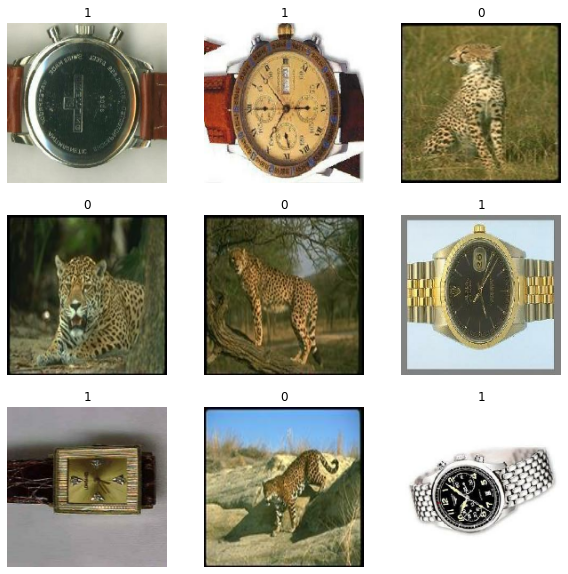

In [ ]:
#Here are the first 9 images in the training dataset. As you can see, label 1 is "watch" and label 0 is "leopard".
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying
#random yet realistic transformations to the training images, such as random horizontal flipping or small random 
#rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


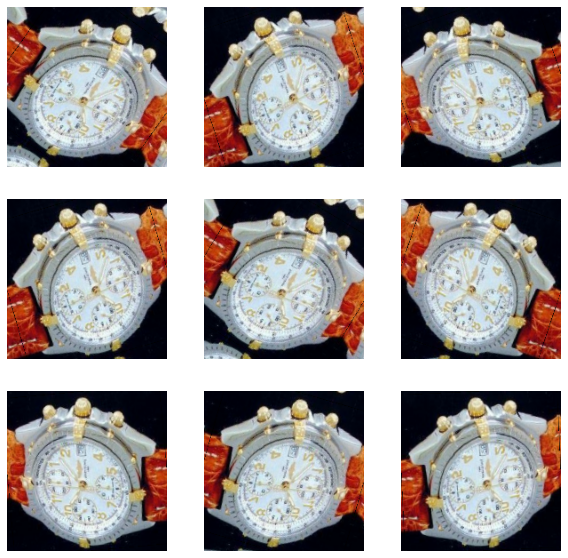

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#Ensures buffered prefetch to be able to generate data from disk without blocking I/O
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
#Build a small version of the Xception network.
#The model is started with the data augmentation preprocessor, followed by a layer of Rescaling
#Including a layer of abandonment before the final classification layer.

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

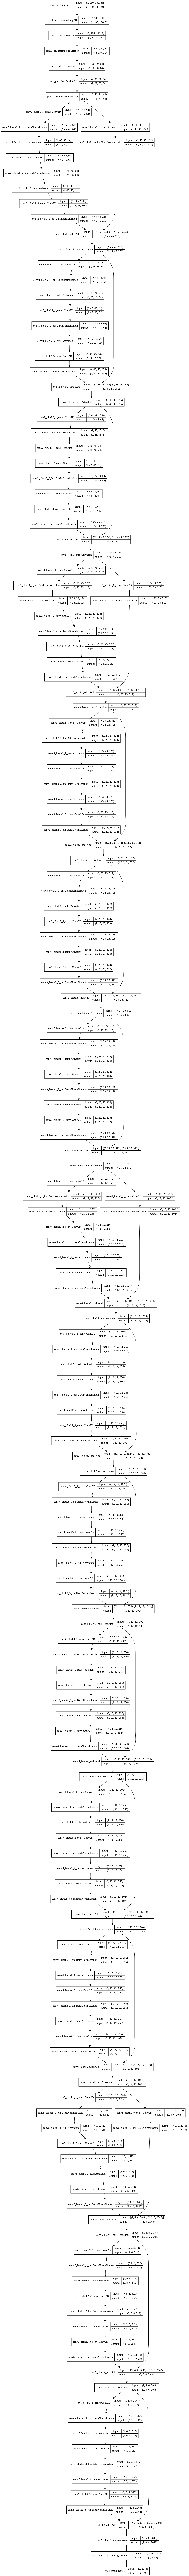

In [ ]:
#Creating the model

model = make_model(input_shape=image_size + (3,), num_classes=2)

model = tf.keras.applications.ResNet50(
    weights= None,
    input_shape=image_size + (3,),
    classes=2
)

#keras.utils.plot_model(model, show_shapes=True)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#Training the model...

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
11/11 [==============================] - 160s 15s/step - loss: 2.6430 - accuracy: 0.4006 - val_loss: 7.6761 - val_accuracy: 0.4138
Epoch 2/10
11/11 [==============================] - 161s 15s/step - loss: 0.8391 - accuracy: 0.5170 - val_loss: 7.6761 - val_accuracy: 0.4138
Epoch 3/10
11/11 [==============================] - 161s 15s/step - loss: 0.7157 - accuracy: 0.5170 - val_loss: 7.4489 - val_accuracy: 0.4023
Epoch 4/10
11/11 [==============================] - 161s 15s/step - loss: 0.7084 - accuracy: 0.4915 - val_loss: 3.3688 - val_accuracy: 0.2644
Epoch 5/10
11/11 [==============================] - 164s 15s/step - loss: 0.7072 - accuracy: 0.5028 - val_loss: 0.8220 - val_accuracy: 0.5402
Epoch 6/10
11/11 [==============================] - 162s 15s/step - loss: 0.7071 - accuracy: 0.4830 - val_loss: 0.7475 - val_accuracy: 0.5862
Epoch 7/10
11/11 [==============================] - 161s 15s/step - loss: 0.7018 - accuracy: 0.5881 - val_loss: 0.7692 - val_accuracy: 0.5862
Epoch 

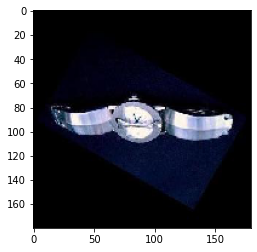

This image is 67.98 percent watch and 32.02 percent leopard.


In [ ]:
#Run inference on new data
img = keras.preprocessing.image.load_img(
    "LeopardosYReloj/watch/image_0007.jpg", target_size=image_size
)

import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score = score[0]
print(
    "This image is %.2f percent watch and %.2f percent leopard."
    % (100 * (1 - score), 100 * score)
)

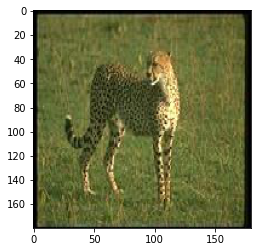

This image is 37.40 percent watch and 62.60 percent leopard.


In [ ]:
#Run inference on new data
img = keras.preprocessing.image.load_img(
    "LeopardosYReloj/Leopards/image_0017.jpg", target_size=image_size
)

import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
score = score[0]
print(
    "This image is %.2f percent watch and %.2f percent leopard."
    % (100 * (1 - score), 100 * score)
)